In [1]:
import numpy as np

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools

G = 4.3009e-9 #km^2 Mpc/ (Msolar  s^2) weird units to make rhom_a good units 

def M_to_R(M, box, a):
    """
    Converts mass of top-hat filter to radius of top-hat filter
    
    Parameters:
        - M (float): Mass of the top hat filter in units Msolor/h
        - box (string): Which Aemulus nu box we're considering 
        - a (float): Redshift 

    Returns:
        - R (float): Corresponding radius of top hat filter Mpc/h
    """

    return (M / (4/3 * math.pi * rhom_a(box, a))) ** (1/3) # h^-1 Mpc  

def R_to_M(R,box, a):
    """
    Converts radius of top-hat filter to mass of top-hat filter
    
    Parameters:
        - R (float): Radius of the top hat filter in units Mpc/h
        - box (string): Which Aemulus nu box we're considering 
        - a (float): Redshift 

    Returns:
        - M (float): Corresponding mass of top hat filter Msolar/h 
    """
    return R ** 3 * 4/3 * math.pi * rhom_a(box, a)

def scaleToRedshift(a):
    return 1/a-1

def redshiftToScale(z):
    return 1/(1+z)
@functools.cache
def sigma2(pk, R):
    """
    Adapated from https://github.com/komatsu5147/MatterPower.jl
    Computes variance of mass fluctuations with top hat filter of radius R
    For this function let k be the comoving wave number with units h/Mpc
    MODIFIED TO MATCH TINKER
    Parameters:
        - pk (funtion): P(k), the matter power spectrum which has units Mpc^3 / h^3
        - R (float): The smoothing scale in units Mpc/h
    Returns:
        - sigma2 (float): The variance of mass fluctuations
    """

    def dσ2dk(k):
        x = k * R
        W = (3 / x) * (np.sin(x) / x**2 - np.cos(x) / x)
        dσ2dk = W * pk(k) * k**2 / 2 / np.pi**2
        return dσ2dk
    res, err = quad(dσ2dk, 0, np.inf)
    σ2 = res
    return σ2

def rhom_a(box, a):
    '''comoving'''
    ombh2 = cosmo['ombh2']
    omch2 = cosmo['omch2']
    H0 = cosmo['H0'] #[km s^-1 Mpc-1]
    h = H0/100 

    Ωm = ombh2/h**2 + omch2/h**2
    
    ΩDE = 1 - Ωm
    wDE = cosmo['w0'] #'wa' is zero for us

    ρcrit0 = 3*H0**2/(8*np.pi*G)/h**2 # h^2 Msol/Mpc^3
    return ρcrit0*(Ωm*a**(-3) + ΩDE*a**(-3*(1+wDE)))*a**3  # h^2 Msol/Mpc^3 

@functools.cache
def dsigma2dR(pk, R):
    """
    Adapated from https://github.com/komatsu5147/MatterPower.jl
    Computes deriative of variance of mass fluctuations wrt top hat filter of radius R
    For this function let k be the comoving wave number with units h/Mpc
    
    Parameters:
        - pk (funtion): P(k), the matter power spectrum which has units Mpc^3 / h^3
        - R (float): The smoothing scale in units Mpc/h
    Returns:
        - dsigma2dR (float): The derivative of the variance of mass fluctuations wrt R
    """

    def dσ2dRdk(k):
        x = k * R
        W = (3 / x) * (np.sin(x) / x**2 - np.cos(x) / x)
        dWdx = (-3 / x) * ((3 / x**2 - 1) * np.sin(x) / x - 3 * np.cos(x) / x**2)
        dσ2dRdk = 2 * W * dWdx * pk(k) * k**3 / 2 / np.pi**2
        return dσ2dRdk
    res, err = quad(dσ2dRdk, 0, 20 / R)
    return res

def dRdM(M, box, a):
    return 1/(6**(2/3)*np.pi**(1/3)*M**(2/3)*rhom_a(box, a)**(1/3))

In [3]:
#https://github.com/tmcclintock/Aemulus_data/blob/e4a2b28571cfba99d8ceda8913fb6e2fd42ab6f3/aemulus_data/building_box_cosmologies.txt
line1 = "# ombh2 omch2 w0 ns ln10As H0 Neff sigma8"
line2 = "2.268324999999999855e-02 1.140598000000000029e-01 -8.165972000000000230e-01 9.755890000000000395e-01 3.092918000000000056e+00 6.336569000000000074e+01 2.918750000000000178e+00 7.730715000000000225e-01"

In [4]:
columns = [col for col in line1.split()[1:]]
cosmo  = dict(zip(columns, np.array(line2.split(), dtype=np.float64)))
print(cosmo)
box = 'Box000'

{'ombh2': 0.02268325, 'omch2': 0.1140598, 'w0': -0.8165972, 'ns': 0.975589, 'ln10As': 3.092918, 'H0': 63.36569, 'Neff': 2.91875, 'sigma8': 0.7730715}


In [5]:
Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'rb')
Pkz = pickle.load(Pk_f)
Pk_f.close()

In [6]:
curr_run_fname = "/oak/stanford/orgs/kipac/aemulus/aemulus_alpha/" + box + "/";


NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+curr_run_fname.split('/')[-2]+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

In [7]:
#deal with floating point errors
a_to_z = dict(zip(NvMs.keys(), Pkz.keys()))
z_to_a = dict(zip(Pkz.keys(), NvMs.keys()))

In [8]:
print(cosmo)

{'ombh2': 0.02268325, 'omch2': 0.1140598, 'w0': -0.8165972, 'ns': 0.975589, 'ln10As': 3.092918, 'H0': 63.36569, 'Neff': 2.91875, 'sigma8': 0.7730715}


In [9]:
#https://github.com/tmcclintock/aemulus_simulation_testing/blob/5edd3b7c30d87f0f715ec974e666ecedd5d48059/bfs/bf_dfg_box0.txt
bf_params = {
    'd0':2.4,
    'd1':2.181047599569275963e+00,
    'e0':8.533560474520303085e-01,
    'e1':4.482167434789784966e-01,
    'f0':2.117323359155323381e-01,
    'f1':0.12,
    'g0':1.308324286279444193e+00,
    'g1':3.444272270175428030e-01
}

In [10]:
# LOOKING_AT = [a_RUN]
from tqdm import trange, tqdm

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d

dlnσinvdMs = {}

vol = -1 #comoving Mpc^3/h^3
Mpart = -1

for z in tqdm(Pkz.keys()):
    a = z_to_a[z]
#     if(a not in LOOKING_AT):
#         continue
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    M_numerics = np.logspace(np.log10(100*Mpart), 17, 100) #h^-1 Msolar
    
    
    R = [M_to_R(m, box, a) for m in M_numerics] #h^-1 Mpc
    
    M_log10 = np.log10(M_numerics)
    sigma2s = [sigma2(Pk, r) for r in R]
    sigma = np.sqrt(sigma2s)
    lnsigmainv = -np.log(sigma)
    dlnsinvdlogM = np.gradient(lnsigmainv, M_log10)
    
    f_dlnsinvdlogM_log = interp1d(M_log10, dlnsinvdlogM,kind='cubic')
#     plt.figure(figsize=(16,8))
#     plt.scatter(M_log10, dlnsinvdlogM, s=5)
#     plt.plot(M_log10, f_dlnsinvdlogM_log(M_log10), c='red')#, s=1)
#     plt.show()
#     break
    f_dlnsinvdM = lambda M: f_dlnsinvdlogM_log(np.log10(M)) / (M * np.log(10)) 

    dlnσinvdMs[a] = f_dlnsinvdM

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_17726/3846093662.py:63: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


In [11]:
from scipy.special import gamma
from scipy.optimize import curve_fit

def p(a, p0, p1):
    oup = (p0)+(a-0.5)*(p1)
    return oup

def B(a, M, σM, d, e, f, g):
    oup = e**(d)*g**(-d/2)*gamma(d/2)
    oup += g**(-f/2)*gamma(f/2)
    oup = 2/oup
    return oup
    
    
def f_G(a, M, σM, d, e, f, g):
    oup = B(a, M, σM, d, e, f, g)
    oup *= ((σM/e)**(-d)+σM**(-f))
    oup *= np.exp(-g/σM**2)
    return oup

def tinker(a, M, 
           d0, d1,
          e0, e1,
          f0, f1,
          g0,g1):
    d = p(a, d0, d1)
    e = p(a, e0, e1)
    f = p(a, f0, f1)
    g = p(a, g0, g1)
    
    R = M_to_R(M, box, a) #Mpc/h
    σM = np.sqrt(sigma2(Pkz[a_to_z[a]], R))  
    oup = f_G(a, M, σM, d, e, f, g)
    oup *= rhom_a(box, a)/M
    oup *= dlnσinvdMs[a](M)
    return oup

/tmp/ipykernel_17726/3846093662.py:63: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


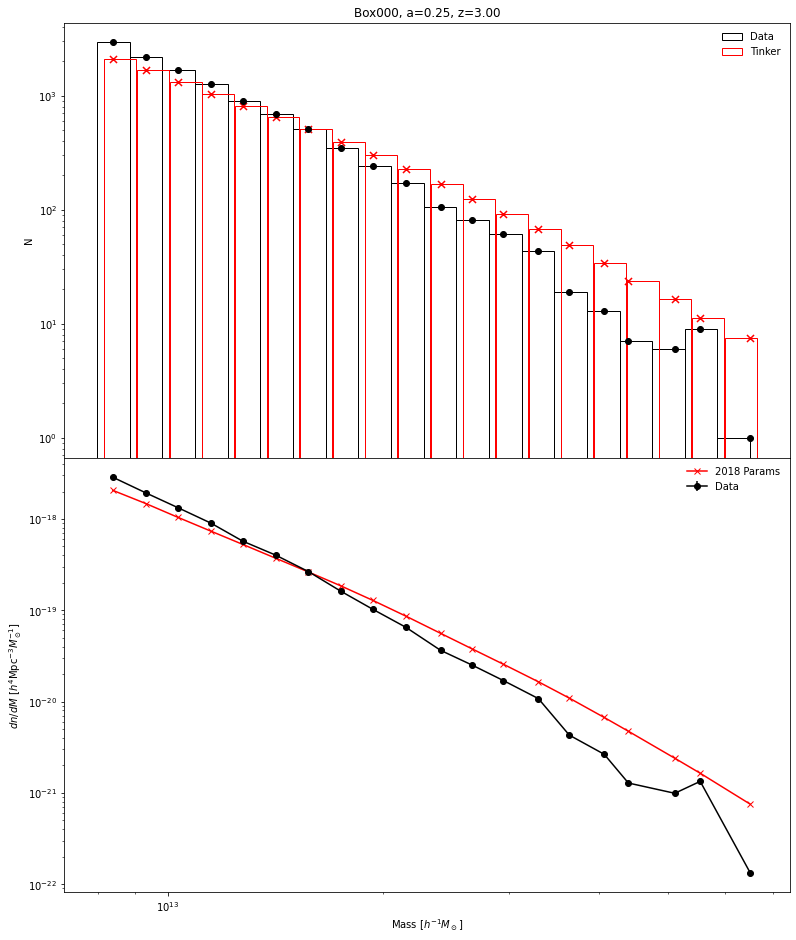

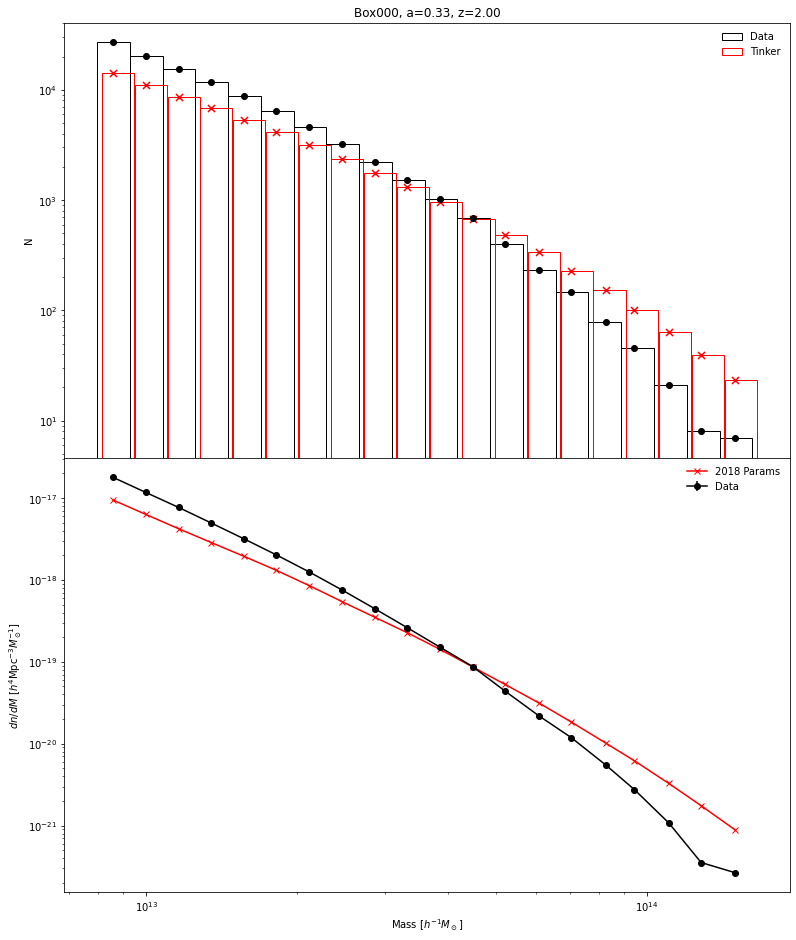

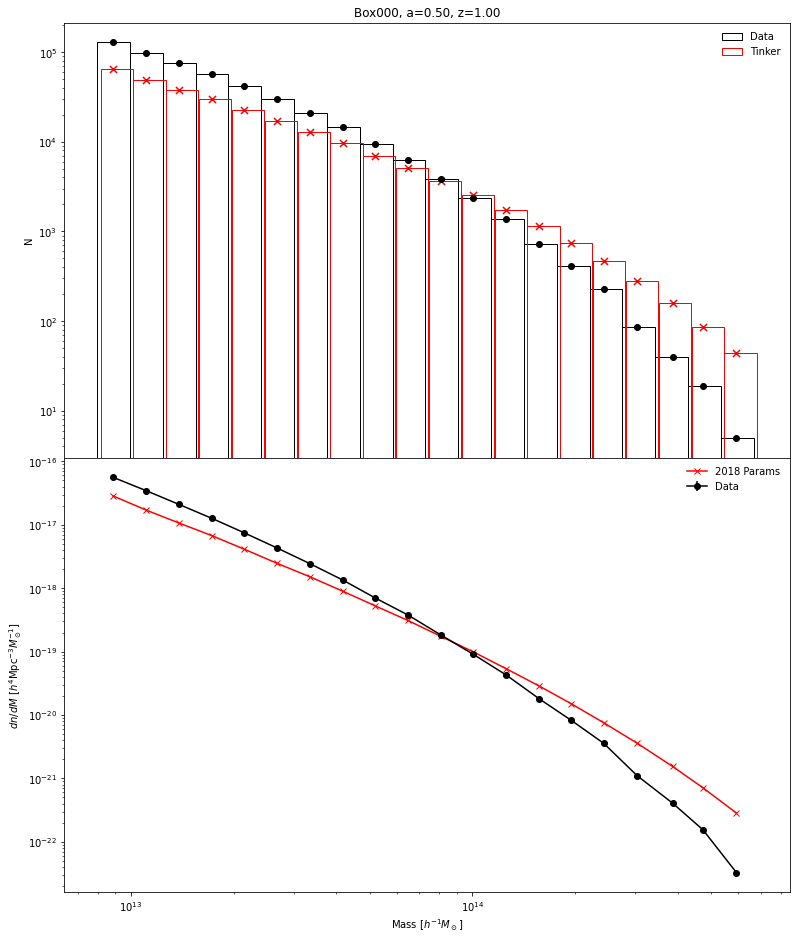

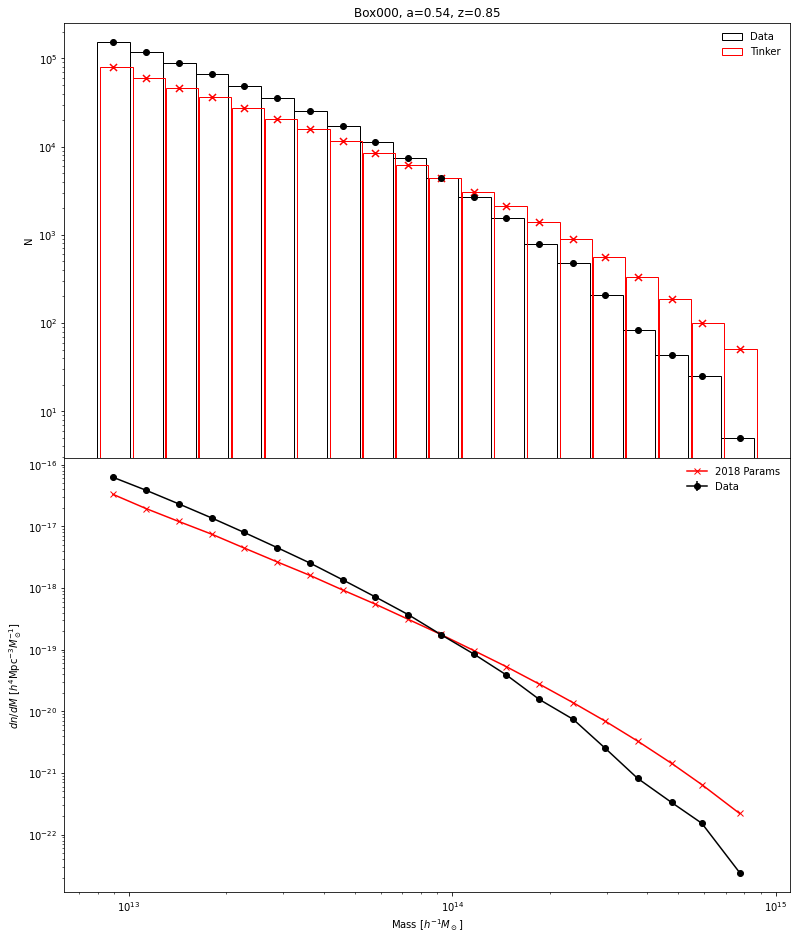

/tmp/ipykernel_17726/3353386436.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  tinker_eval = np.array([quad(f_dndM, edge[0],  edge[1])[0] for edge in edge_pairs])


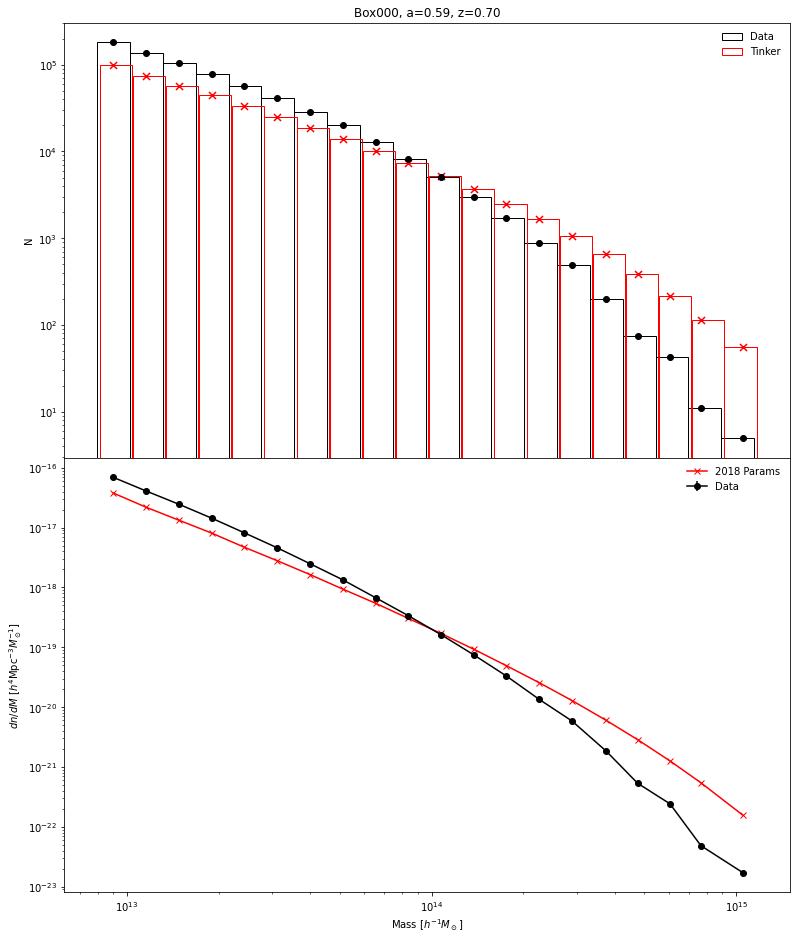

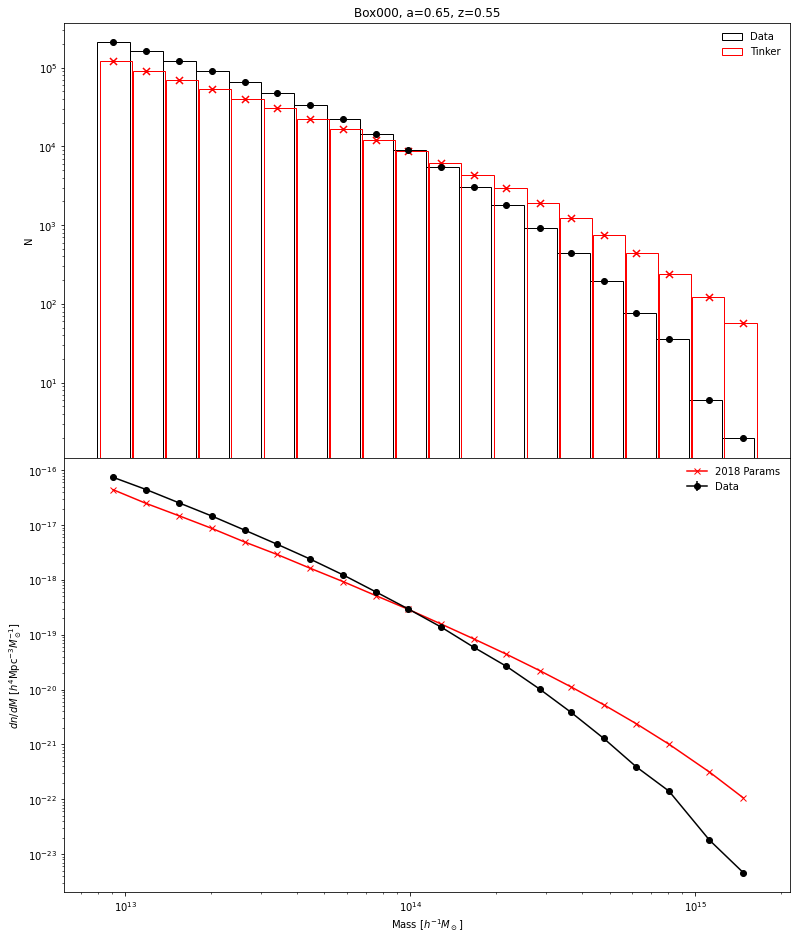

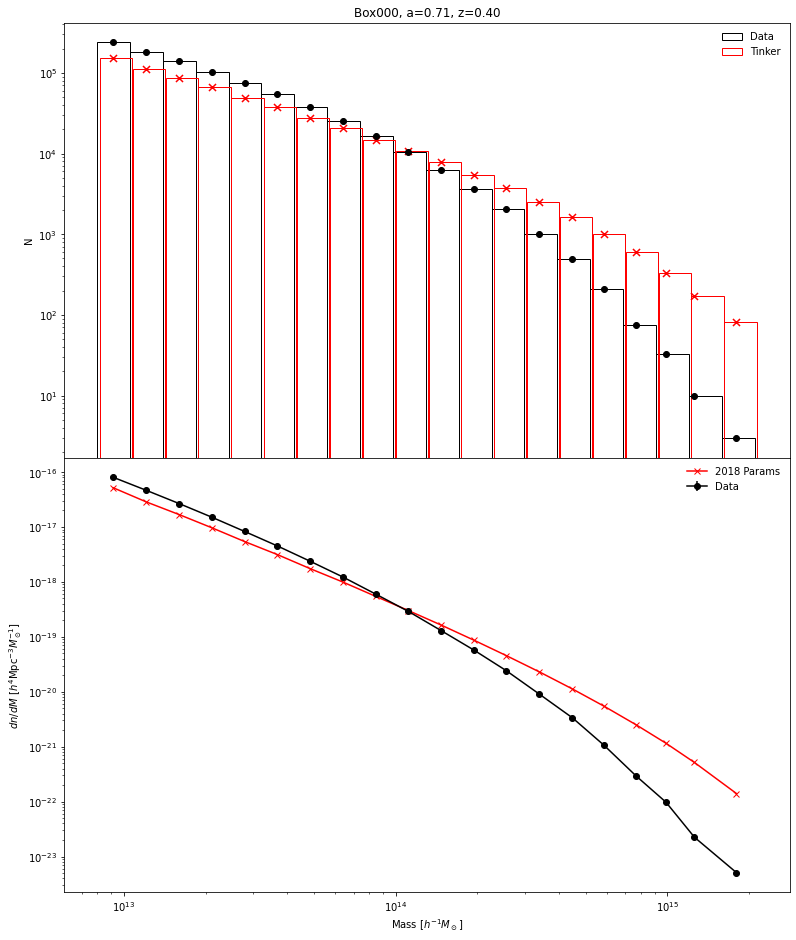

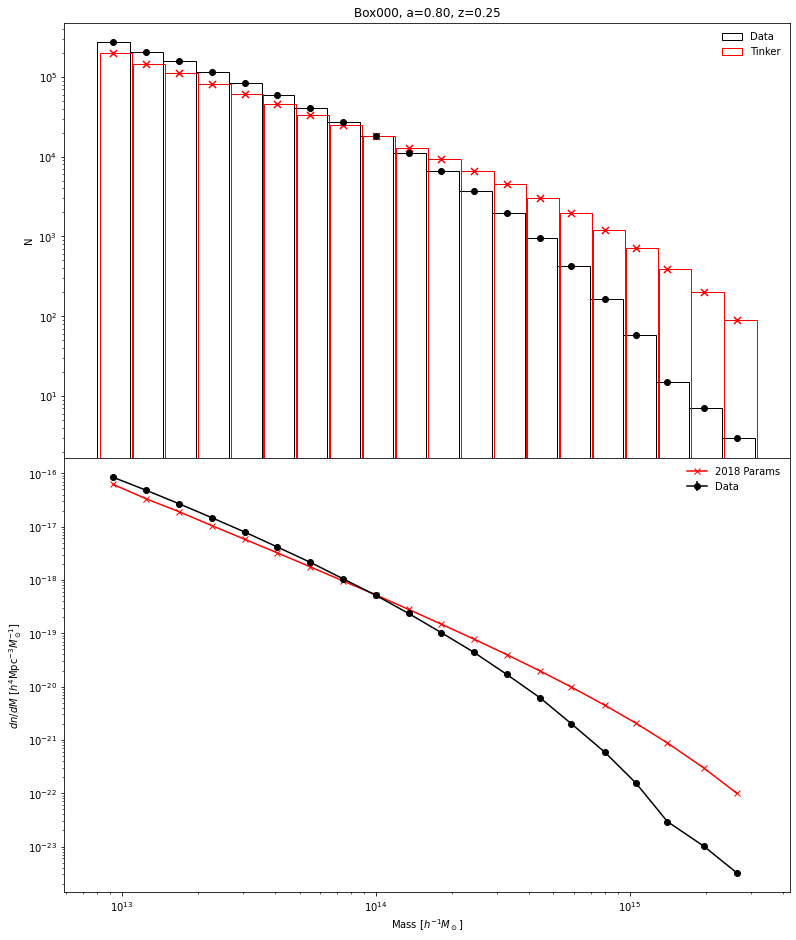

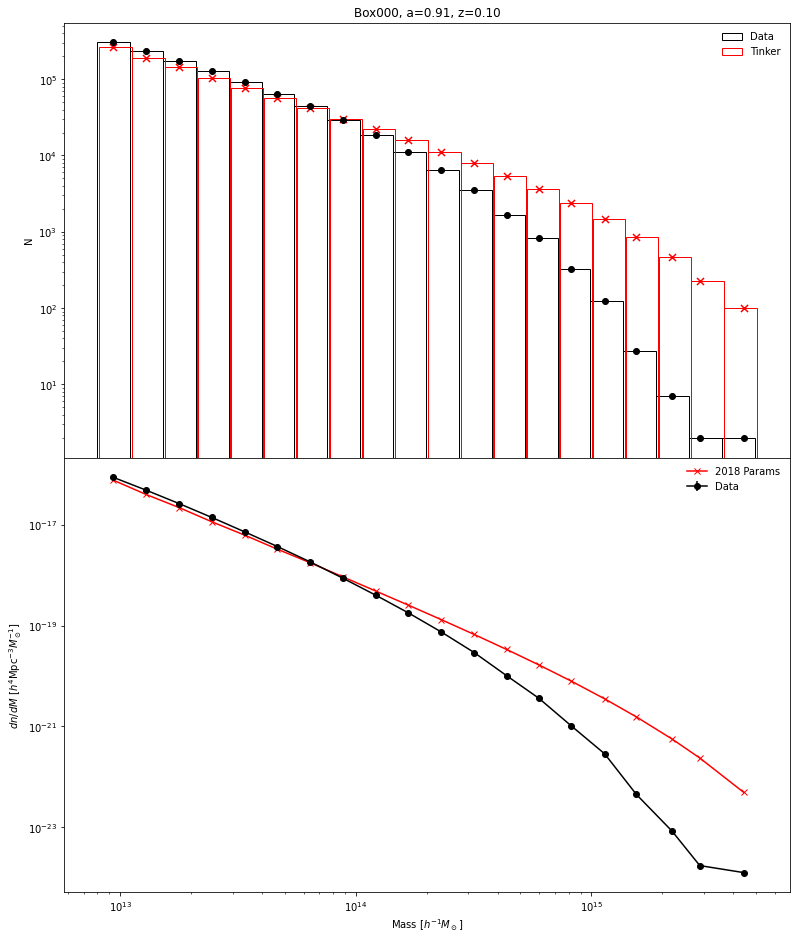

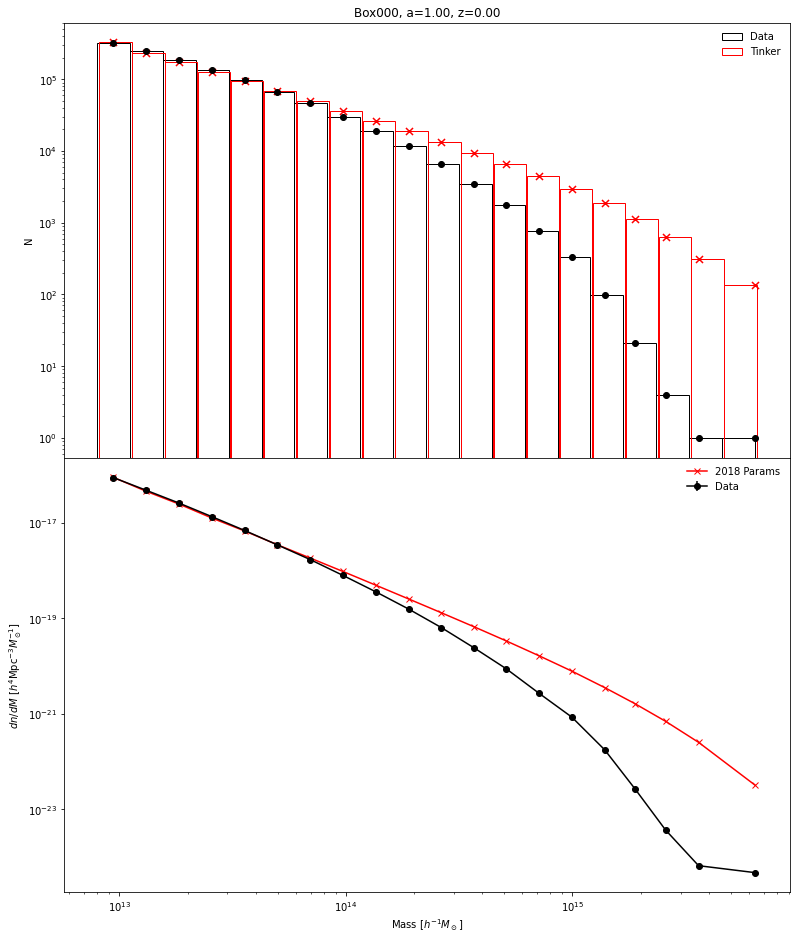

In [12]:
from scipy.interpolate import interp1d
i=0
for a in N_data:
    z = a_to_z[a]
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,16))
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = M_data[a]
    N = np.array(N_data[a])
    edge_pairs = c_data['edge_pairs']
    
    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (np.array(N)/vol)/dM

    tinker_eval = [tinker(a, M_c,**bf_params) for M_c in Ms]
    yerr = np.zeros_like(Ms) 

    axs[1].errorbar(Ms, dndM, yerr/(vol)/dM, fmt='o-', color='black', label='Data')
    axs[1].plot(Ms, tinker_eval, 'x-', color='red', label='2018 Params')



    tinker_eval = [tinker(a, M_c,**bf_params,)*vol for M_c in M_numerics]
    
    f_dndM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    
    tinker_eval = np.array([quad(f_dndM, edge[0],  edge[1])[0] for edge in edge_pairs])

    color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]

    
    axs[0].errorbar(Ms, N, yerr, fmt='o', c='black')
    axs[0].scatter(Ms, tinker_eval, s=50 , marker='x', c='red')
    
    
    edges = np.array(edges)
    tmp = edges[:-1]*10**(0.01)-edges[:-1]
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
               align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1]+tmp, height=tinker_eval, width=np.diff(edges), align='edge', fill=False, ec='red', label='Tinker')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].legend(frameon=False)
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$dn/dM\ [h^4{\rm Mpc}^{-3}M_\odot^{-1}]$')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, a_to_z[a]))
    i+=1
    plt.show()
